In [1]:
# Esteban Barrios

import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.stats import uniform
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

from mpl_toolkits.mplot3d import Axes3D

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv('./ABtesting_zapatillas.csv')
data

,A,B
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,1,1
99998,1,0


In [3]:
n_sample = 10000
np.random.seed(777) # El valor de random_state garantiza reproducibilidad
df = data.sample(n=n_sample)  
# Reinicio némero de index
df.reset_index(drop=True, inplace=True)
df = data

# Dostribución previa

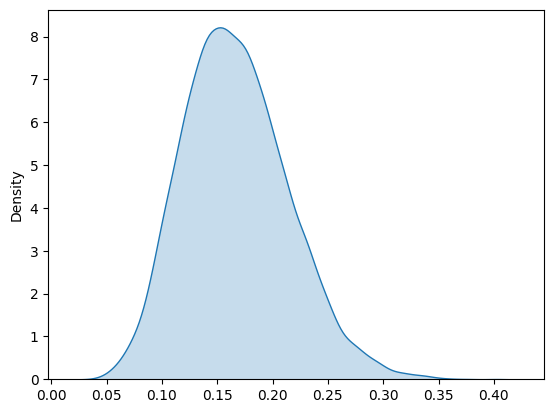

In [4]:
alpha_prior = 10
beta_prior = 50

prior_draws = np.random.beta(alpha_prior,beta_prior,n_sample)
# Plot density of posterior_draws
sns.kdeplot(prior_draws, fill=True)
plt.show()

## (a) Calcula y grafica la distribución posterior para las dos versiones A y B usando priorconjugado.

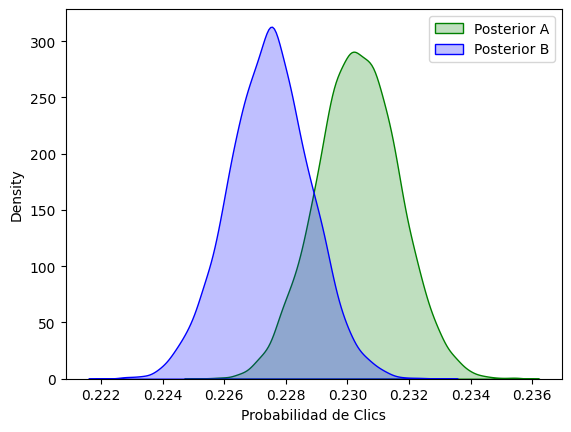

In [5]:
# Definir Alpha y Beta para muestra A
alpha_posterior_a = alpha_prior + sum(df["A"])
beta_posterior_a = beta_prior + len(df["A"]) - sum(df["A"])

# Definir Alpha y Beta para muestra B
alpha_posterior_b = alpha_prior + sum(df["B"])
beta_posterior_b = beta_prior + len(df["B"]) - sum(df["B"])

# Deginir Posteriores para A y para B
posterior_a_draws = np.random.beta(alpha_posterior_a,beta_posterior_a,n_sample)
posterior_b_draws = np.random.beta(alpha_posterior_b,beta_posterior_b,n_sample)

# Graficar posteriores
sns.kdeplot(posterior_a_draws, fill=True, color="green", label="Posterior A")
sns.kdeplot(posterior_b_draws, fill=True, color="blue", label="Posterior B")
plt.legend(loc='upper right')
plt.xlabel('Probabilidad de Clics')
plt.show()

## (b) Calcula y grafica la distribución posterior para las dos versiones A y B usando muestreo Monte Carlo Markov Chain.

In [6]:

# Crear el modelo en PyMC
with pm.Model() as coin_model:
    # Prior beta 
    p_A = pm.Beta("p_A", 10, 50)
    p_B = pm.Beta("p_B", 10, 50)

    # Verosimilitud
    likelihood_A = pm.Bernoulli("likelihood_A", p_A, observed=data["A"])
    likelihood_B = pm.Bernoulli("likelihood_B", p_B, observed=data["B"])
    
    # Realizar el muestreo de la cadena de Markov Monte Carlo
    trace = pm.sample(1000, tune=1000, chains=2)

# Resultados del muestreo
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_A, p_B]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_A,0.230,0.001,0.228,0.233,0.0,0.0,1975.0,1485.0,1.0
p_B,0.227,0.001,0.225,0.230,0.0,0.0,1989.0,1379.0,1.0


array([[<AxesSubplot: title={'center': 'p_A'}>,
        <AxesSubplot: title={'center': 'p_A'}>],
       [<AxesSubplot: title={'center': 'p_B'}>,
        <AxesSubplot: title={'center': 'p_B'}>]], dtype=object)

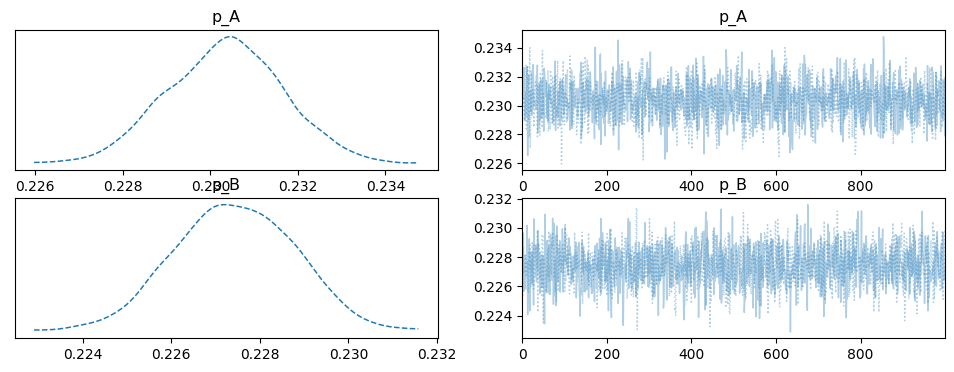

In [7]:
az.plot_trace(trace, combined=True)

### Guardamos los valores de las distribuciones posteriores en listas diferentes (para guardar solo posterior elegir el segundo elemento de la lista resultante).
### Trans en un array de numpy para poder hacerle transformacioens numericas más facil.

In [8]:
posterior_A = trace.posterior["p_A"].values.tolist()
posterior_A = posterior_A[1]
posterior_A = np.array(posterior_A)

posterior_B = trace.posterior["p_B"].values.tolist()
posterior_B = posterior_B[1]
posterior_B = np.array(posterior_B)

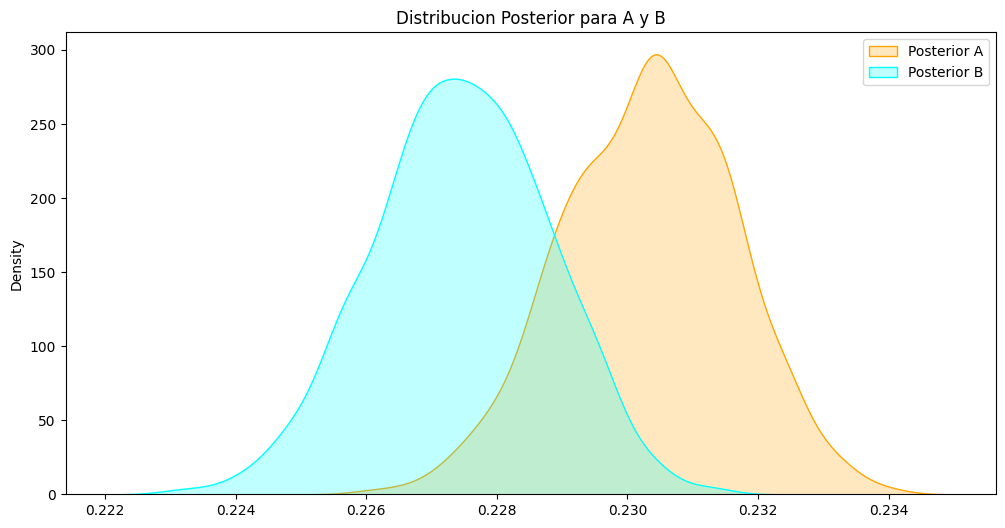

In [9]:
plt.figure(figsize=(12, 6))
sns.kdeplot(posterior_A, fill=True, color="orange", label="Posterior A")
sns.kdeplot(posterior_B, fill=True, color="cyan", label="Posterior B")
plt.title('Distribucion Posterior para A y B')
plt.legend(loc='upper right')
plt.show()

## (c) Cuál versión es mejor? Explica tu respuesta.

En este caso me parece mejor el resultado de Posterior B, ya que está más proximo al valor 1, estando a la derecha de Posterior A

## (d) Qué tan probable es que la versión A sea más efectiva?

#### Para Prior Conjugado

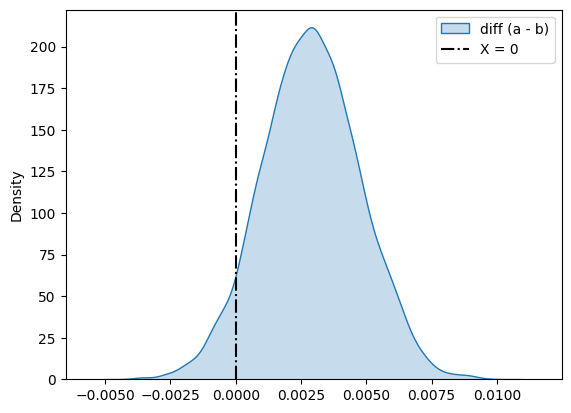

0.9398
93.97999999999999 % de probabilidad de A ser mejor que B
6.020000000000003 % de probabilidad de B ser mejor que A


In [ ]:
# Calcular la diferencia entre las posteriores
diff = posterior_a_draws - posterior_b_draws
sns.kdeplot(diff, fill=True, label="diff (a - b)")
plt.axvline(x=0, color='black', linestyle='-.', label='X = 0')
plt.legend(loc='upper right')
plt.show()

# Calcular la probabilidad que A sea mejor que B
# (prob posterior a > prob posterior b).mean()
oldpage_better_prob = (diff>0).mean()
print(oldpage_better_prob)
print(oldpage_better_prob*100, "% de probabilidad de A ser mejor que B")
print((1-oldpage_better_prob)*100, "% de probabilidad de B ser mejor que A")

#### Para MCMC

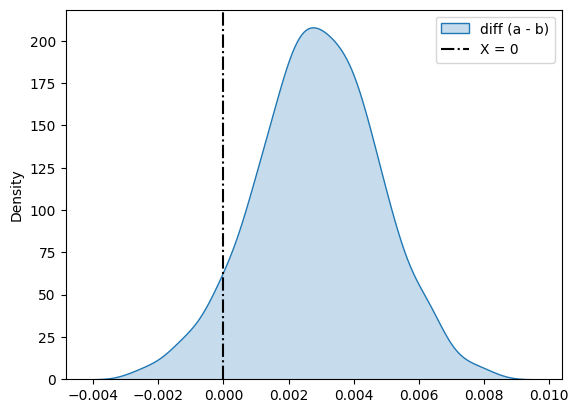

0.931
93.10000000000001 % de probabilidad de A ser mejor que B
6.899999999999995 % de probabilidad de B ser mejor que A


In [11]:
# Calcular la diferencia entre las posteriores
diff = posterior_A - posterior_B
sns.kdeplot(diff, fill=True, label="diff (a - b)")
plt.axvline(x=0, color='black', linestyle='-.', label='X = 0')
plt.legend(loc='upper right')
plt.show()

# Calcular la probabilidad que A sea mejor que B
# (prob posterior a > prob posterior b).mean()
oldpage_better_prob = (posterior_A > posterior_B).mean()
print(oldpage_better_prob)
print(oldpage_better_prob*100, "% de probabilidad de A ser mejor que B")
print((1-oldpage_better_prob)*100, "% de probabilidad de B ser mejor que A")

## (e) Completa siguiente afirmación: Con 95% de probabilidad, la tasa de clic de la versión(...) es hasta (...)% superior a la versión (...).

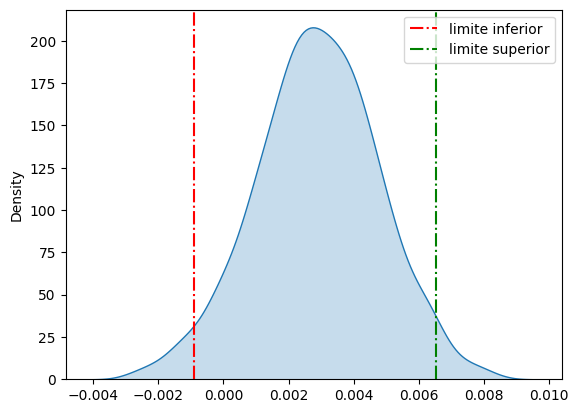

[-0.00090663  0.00652944]
Con 95% de probabilidad, la tasa de clic de la versión A es hasta  0.6529437330262899 % superior a la versión B


In [13]:
# Calcular HDI 95% de la diferencia
interval = az.hdi(diff, hdi_prob=0.95)
sns.kdeplot(diff, fill=True)
plt.axvline(x=interval[0], color='red', linestyle='-.', label='limite inferior')
plt.axvline(x=interval[1], color='green', linestyle='-.', label='limite superior')
plt.legend(loc='upper right')
plt.show()

print(interval)
print("Con 95% de probabilidad, la tasa de clic de la versión A es hasta ", float(interval[1]*100) ,"% superior a la versión B")

## (f) Sabiendo que cada clic resulta en $10 de ganancia, grafica la distribución de ganancias para las dos versiones usando forest plot y explica los resultados

array([<AxesSubplot: title={'center': '95.0% HDI'}>], dtype=object)

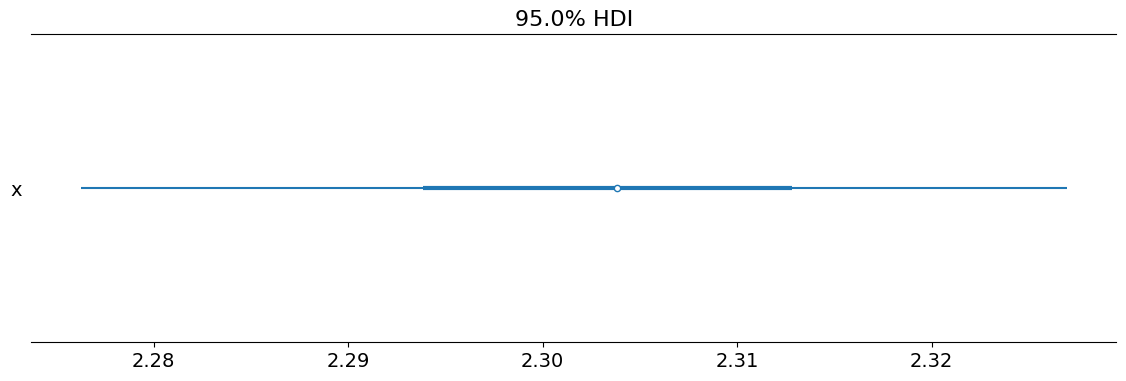

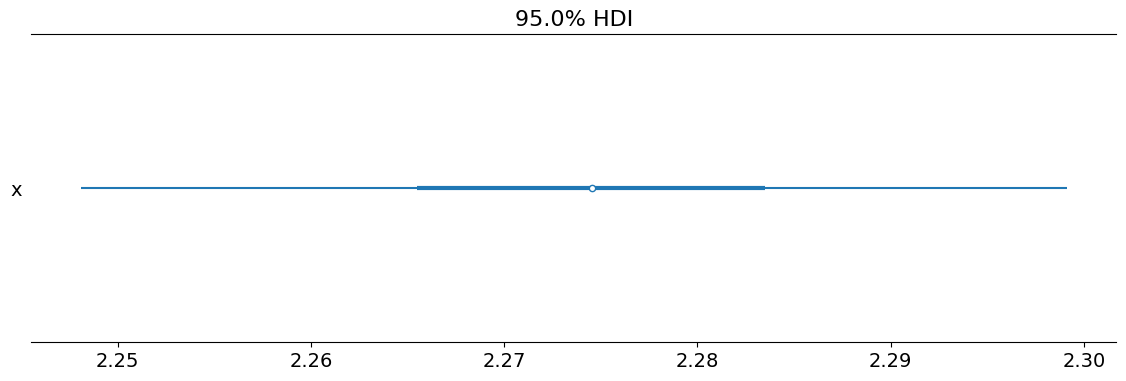

In [17]:
pm.plot_forest(posterior_A*10, hdi_prob = 0.95, figsize = (14,4))
pm.plot_forest(posterior_B*10, hdi_prob = 0.95, figsize = (14,4))